In [108]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
import numpy as np

In [109]:
encoder = OrdinalEncoder()

In [110]:
df = pd.read_csv('merged_df.csv')

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43485 entries, 0 to 43484
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Company                43485 non-null  object 
 1   Vehicle_Model          43485 non-null  object 
 2   Engine_Displacement_L  43485 non-null  float64
 3   Engine_Cylinders       43485 non-null  int64  
 4   Transmission_Type      43485 non-null  object 
 5   Drive                  43485 non-null  object 
 6   Fuel                   43485 non-null  object 
 7   Cert_Region            43485 non-null  object 
 8   Veh_Class              43485 non-null  object 
 9   Air_Pollution_Score    43485 non-null  float64
 10  City_Mpg               43485 non-null  int64  
 11  Hwy_Mpg                43485 non-null  int64  
 12  Combined_Mpg           43485 non-null  int64  
 13  Greenhouse_Gas_Score   43485 non-null  int64  
 14  Smartway               43485 non-null  object 
 15  Co

In [112]:
df['Smartway'] = df['Smartway'].map({'No': 0, 'Yes': 1, 'Elite': 2})

In [113]:
list_cat = ['Company', 'Engine_Displacement_L', 'Transmission_Type', 'Drive', 'Fuel', 'Cert_Region', 'Veh_Class']

In [114]:
df = df[df['Engine_Displacement_L'] > 0]
df.describe()

,Engine_Displacement_L,Engine_Cylinders,Air_Pollution_Score,City_Mpg,Hwy_Mpg,Combined_Mpg,Greenhouse_Gas_Score,Smartway,Combined_Co2,year
count,43481.000000,43481.000000,43481.000000,43481.000000,43481.000000,43481.000000,43481.000000,43481.000000,43481.000000,43481.000000
mean,3.221333,5.689842,5.446885,20.915641,27.483522,23.322900,4.878729,0.187737,409.913203,2016.564085
std,1.339133,1.870135,1.545448,10.071594,9.074845,9.535283,1.924540,0.412782,112.632218,5.004896
min,0.600000,2.000000,1.000000,7.000000,11.000000,9.000000,0.000000,0.000000,0.000000,2008.000000
25%,2.000000,4.000000,5.000000,16.000000,22.000000,18.000000,4.000000,0.000000,340.000000,2012.000000
50%,3.000000,6.000000,6.000000,19.000000,26.000000,22.000000,5.000000,0.000000,406.000000,2017.000000
75%,3.800000,6.000000,6.000000,23.000000,31.000000,26.000000,6.000000,0.000000,476.000000,2021.000000
max,8.400000,16.000000,9.500000,145.000000,121.000000,133.000000,10.000000,2.000000,979.000000,2025.000000


In [115]:
df[list_cat] = encoder.fit_transform(df[list_cat])

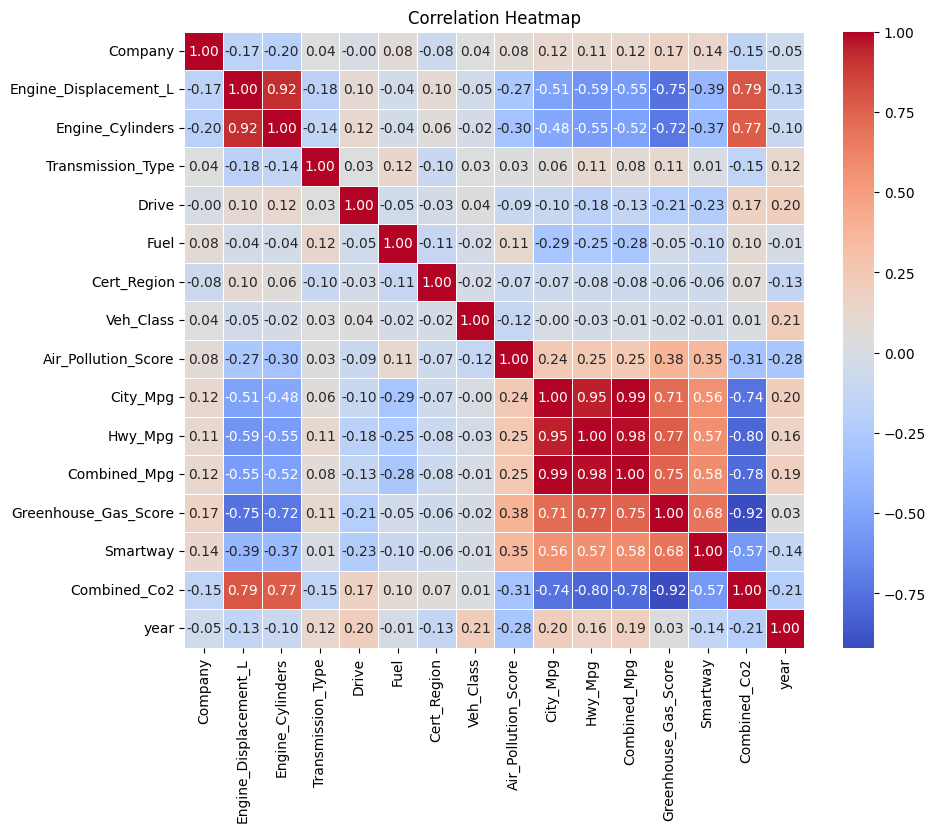

In [116]:
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


In [117]:
selected_features = [
  'Engine_Displacement_L',
  'Engine_Cylinders',
  'Combined_Mpg',
  'Greenhouse_Gas_Score',
  'Combined_Co2',
  'Smartway'
]

df_cluster = df[selected_features].dropna()


In [118]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

features_to_scale = ['Engine_Displacement_L', 'Engine_Cylinders', 'Combined_Mpg', 'Greenhouse_Gas_Score', 'Combined_Co2']
X_scaled = scaler.fit_transform(df_cluster[features_to_scale])

X_final = np.hstack([X_scaled, df_cluster[['Smartway']].values])  # append Smartway as-is

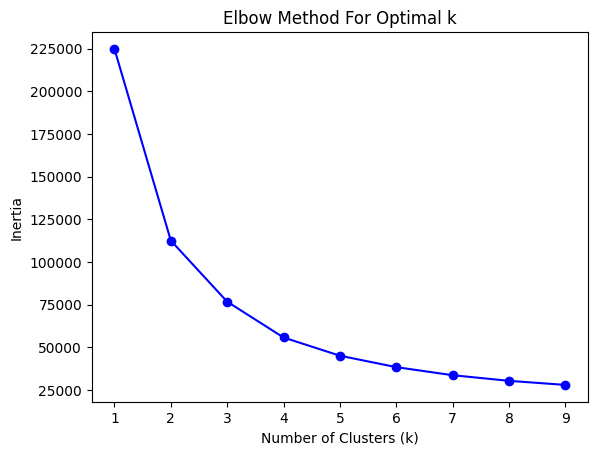

In [119]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_final)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()


In [120]:
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(X_scaled)

df_cluster['Cluster'] = labels

Smartway      0     1    2
Cluster                   
0          9584    15    0
1         15056   268    0
2         10878  5951   49
3           189  1151  340


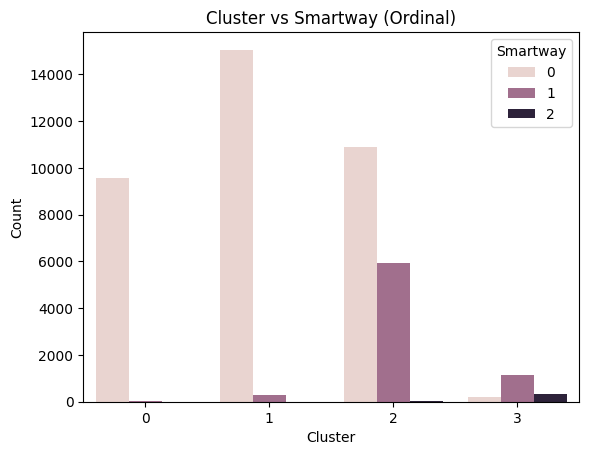

In [121]:
# Crosstab = how many cars from each Smartway category ended up in each cluster
print(pd.crosstab(df_cluster['Cluster'], df_cluster['Smartway']))
sns.countplot(data=df_cluster, x='Cluster', hue='Smartway')
plt.title('Cluster vs Smartway (Ordinal)')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Smartway')
plt.show()


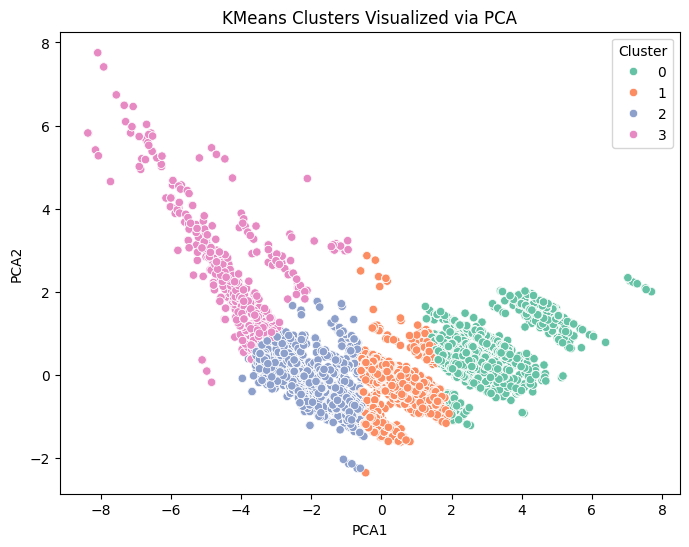

In [122]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

df_cluster['PCA1'] = pca_result[:, 0]
df_cluster['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_cluster, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
plt.title('KMeans Clusters Visualized via PCA')
plt.show()


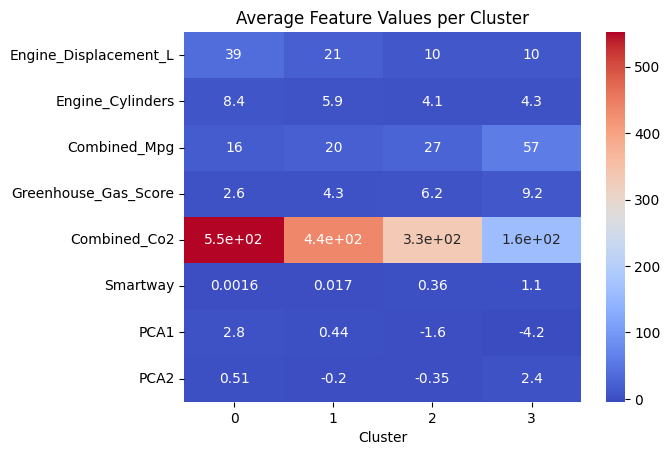

In [123]:
df_cluster.groupby('Cluster').mean().round(2)
sns.heatmap(df_cluster.groupby('Cluster').mean().T, annot=True, cmap="coolwarm")
plt.title("Average Feature Values per Cluster")
plt.show()


Cluster 0: (trucks, V8) 
  - Engine: Huge (Displacement: 39, Cylinders: 8.4)
  - Fuel Efficiency: Low (MPG: 16, C02: 550+ g/km)
  - Greenhouse Score: 2.6
  - Smartway: 0.0016

Cluster 1: (Common Sedans & SUVs)
  - Engine: Still beefy, but tamer (Displacement: 21, Cylinders: 5.9)
  - MPG: Mid-level (20), CO₂: 440
  - Greenhouse Score: 4.3
  - Smartway: 0.017

Cluster 2: (Mild Hybrids)
  - Engine: Smallest (Displacement: 10, Cylinders: 4.1)
  - MPG: (27), CO₂: (330)
  - Smartway: 0.36
  - Greenhouse Score: 6.2

Cluster 3: (Hybrid, EVs)
  - Engine: Smallest (Displacement: 10, Cylinders: 4.3)
  - MPG: (57), CO₂: (160)
  - Smartway: 1.1
  - Greenhouse Score: 9.2